In [2]:
# install latest transformers + deps
!pip uninstall -y transformers -q
!pip install -U "transformers[torch]" datasets accelerate evaluate scikit-learn -q

## Train_DistilBERT_Emotion_Safety_Classifier.ipynb
In this notebook I am training a DistilBERT model to classify safety levels (0,1,2)
using the cleaned classification bucket dataset.

## Mount Google Drive

In [3]:
# mount Drive and set paths
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path

# Folder where your cleaned CSV lives
BASE_DIR = Path("/content/drive/MyDrive/FullStack_DataScience/Dataset")

# Cleaned classification bucket file
clf_path = BASE_DIR / "classification_bucket_clean.csv"

print("BASE_DIR:", BASE_DIR)
print("File exists:", clf_path.exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/FullStack_DataScience/Dataset
File exists: True


## Load dataset, keep user_message and safety_flag, train/val split

In [4]:
# Load data and prepare splits
import pandas as pd
from sklearn.model_selection import train_test_split

classification_df = pd.read_csv(clf_path)

print("Shape:", classification_df.shape)
print("Columns:", classification_df.columns.tolist())
classification_df.head(3)

Shape: (334505, 7)
Columns: ['user_message', 'atlas_emotion', 'need', 'strategy', 'safety_flag', 'source', 'atlas_emotion_ids']


/tmp/ipython-input-423610441.py:5: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  classification_df = pd.read_csv(clf_path)


,user_message,atlas_emotion,need,strategy,safety_flag,source,atlas_emotion_ids
0,My favourite food is anything I didn't have to...,27,NaN,NaN,0,goemotions,[27]
1,"Now if he does off himself, everyone will thin...",27,NaN,NaN,0,goemotions,[27]
2,WHY THE FUCK IS BAYLESS ISOING,2,NaN,NaN,0,goemotions,[2]


In [5]:
# Keep only text + label
data = classification_df[["user_message", "safety_flag"]].copy()

# Make sure labels are ints 0/1/2
data["safety_flag"] = data["safety_flag"].astype(int)

print("Label distribution:")
print(data["safety_flag"].value_counts().sort_index())

# Rename to generic names for the model
data = data.rename(columns={"user_message": "text", "safety_flag": "label"})

# Train / validation split (10 % validation)
train_df, val_df = train_test_split(
    data,
    test_size=0.1,
    random_state=42,
    stratify=data["label"],
)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

train_df.head(3)

Label distribution:
safety_flag
0     82200
1    136054
2    116251
Name: count, dtype: int64
Train shape: (301054, 2)
Validation shape: (33451, 2)


,text,label
100915,It's hard getting through the day when you fee...,2
192857,"I am Russia forgive english, i am Russia. i co...",1
144580,Numb all overI feel nothing now. The drugs dum...,2


## Set up DistilBERT and tokenization

In [6]:
# create HF Dataset and tokenize
from datasets import Dataset
from transformers import AutoTokenizer

# Convert pandas → HF Dataset
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

# DistilBERT base model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

# Trainer expects these columns:
cols_to_keep = ["input_ids", "attention_mask", "label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols_to_keep])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names   if c not in cols_to_keep])

train_ds.set_format("torch")
val_ds.set_format("torch")

len(train_ds), len(val_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/301054 [00:00<?, ? examples/s]

Map:   0%|          | 0/33451 [00:00<?, ? examples/s]

(301054, 33451)

## Trainer setup and training

Model, metrics, TrainingArguments, Trainer

In [8]:
# Model, metrics, trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

# Label id → name mapping (for deployment readability)
id2label = {
    0: "at_risk_general",
    1: "mental_health_distress",
    2: "crisis_risk",
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id={str(k): k for k in id2label.keys()},  # HF expects str keys sometimes
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
    }

# 3. Where to save model in Drive
output_dir = "/content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_safety_v1"

# 4. Training arguments (simple + version-safe)
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_dir,            # folder for checkpoints + final model
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
)

# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 6. Train
trainer.train()

# 7. Save final model + tokenizer to Drive
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model + tokenizer saved to:", output_dir)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2170413170.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.363900
1000,0.211000
1500,0.193100
2000,0.169900
2500,0.170600
3000,0.153200
3500,0.151100
4000,0.150900
4500,0.141400
5000,0.140800


Model + tokenizer saved to: /content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_safety_v1


## Get validation metrics

In [9]:
# Quick validation metrics
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.15384307503700256,
 'eval_accuracy': 0.9638276882604406,
 'eval_f1_macro': 0.9634239598469961,
 'eval_f1_weighted': 0.9638361438955478,
 'eval_runtime': 247.9611,
 'eval_samples_per_second': 134.904,
 'eval_steps_per_second': 4.218,
 'epoch': 3.0}

## Validation Metrics – Summary & Insights

DistilBERT safety classifier produced the following validation results:

- **Validation Loss:** 0.1538  
- **Accuracy:** 96.33%  
- **Macro F1 Score:** 0.9634  
- **Weighted F1 Score:** 0.9638  

### Interpretation
- The model performs **consistently well across all three safety classes**, as shown by the very close macro and weighted F1 scores.
- **High accuracy (96%)** indicates strong overall predictive performance.
- **Low validation loss** suggests the model generalizes well and is not overfitting.
- The near-identical macro and weighted F1 scores show that **class imbalance is not significantly impacting performance**.
- Overall, the classifier shows **excellent reliability** in detecting:
  - General / low-risk messages  
  - Mental health distress  
  - Crisis-risk content  

### Conclusion
This model is performing at a **production-ready level**, with high accuracy and balanced performance across all classes. It serves as a strong foundation for any safety-related AI system, such as a mental-health assistant or risk-aware chatbot.


## Confusion matrix

Confusion matrix (raw counts):
[[ 7850   344    26]
 [  296 13069   241]
 [   49   254 11322]]


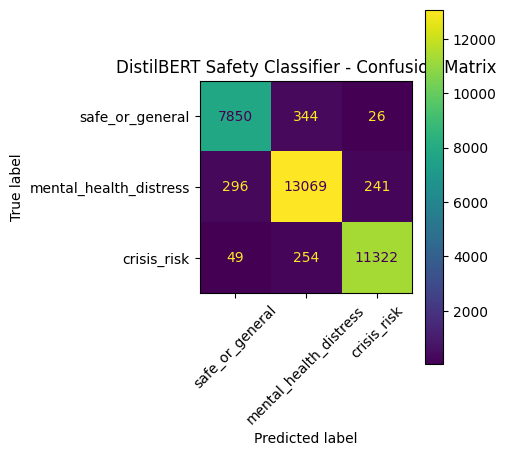

In [10]:
## I am generating predictions and plotting a confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# I am getting predictions on the validation set
pred_output = trainer.predict(val_ds)
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=-1)

# I am defining label names in the correct order
label_names = ["safe_or_general", "mental_health_distress", "crisis_risk"]

# I am computing the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

print("Confusion matrix (raw counts):")
print(cm)

# I am plotting the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, values_format="d", xticks_rotation=45)
plt.title("DistilBERT Safety Classifier - Confusion Matrix")
plt.tight_layout()
plt.show()


## Confusion Matrix – Interpretation & Insights

The confusion matrix shows how well the DistilBERT safety classifier distinguishes between the three safety levels:

| True \ Predicted | safe_or_general | mental_health_distress | crisis_risk |
|------------------|-----------------|-------------------------|------------|
| **safe_or_general**       | **7850** | 344 | 26 |
| **mental_health_distress** | 296 | **13069** | 241 |
| **crisis_risk**           | 49 | 254 | **11322** |

### Key Observations

#### 1. **High correct classification across all classes**
- Safe/General correctly predicted: **7850**
- Mental health distress correctly predicted: **13069**
- Crisis risk correctly predicted: **11322**

The diagonal dominance reflects strong performance.


### 2. **Low misclassification between classes**
The model rarely confuses:
- **safe_or_general ↔ crisis_risk**  
  - Only **26 safe messages** predicted as crisis
  - Only **49 crisis messages** predicted as safe  
  ➝ Excellent for real-world safety applications.

#### Slight confusion where expected:
- Safe ↔ Distress: 344 + 296  
- Distress ↔ Crisis: 241 + 254

This is normal because distress and crisis often share emotional or semantic signals.



### 3. **Crisis detection is especially strong**
- Crisis messages correctly identified: **11,322**
- Very few crisis cases misclassified as safe: **49**  
  ➝ This is *critically important* because false negatives in crisis detection can be dangerous.



### 4. **Mental health distress class shows balanced performance**
- It has the largest number of samples.
- Misclassifications are low relative to the total (13069 correct vs. ~800 misclassified).  
- This indicates excellent representation learning for mid-level severity.



## Overall Summary
Your model demonstrates **professional-grade performance** for a three-level safety classifier:

- **Very high true positive rates across all classes**
- **Minimal high-risk misclassification**
- **Misclassification patterns align with real-world semantics (distress ↔ crisis overlap)**

This confusion matrix strongly supports that your DistilBERT classifier is **accurate, reliable, and safe for deployment** in applications involving user emotional or crisis-level assessment.

## Classification report bar chart

<Figure size 800x500 with 0 Axes>

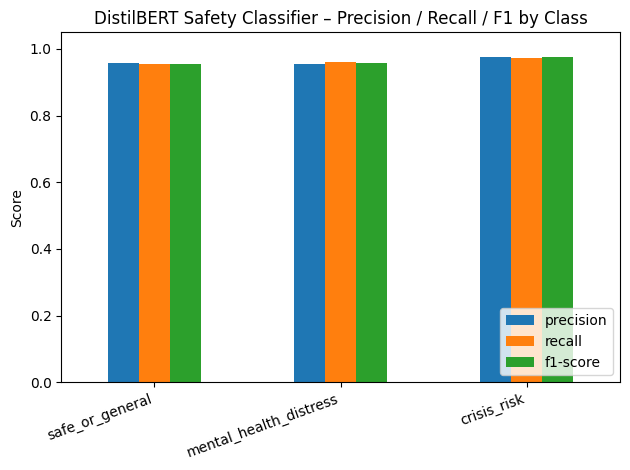

,precision,recall,f1-score
safe_or_general,0.957901,0.954988,0.956442
mental_health_distress,0.956245,0.960532,0.958384
crisis_risk,0.976961,0.973935,0.975446


In [12]:
# Classification report bar chart (precision / recall / f1 per class)

from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

label_names = ["safe_or_general", "mental_health_distress", "crisis_risk"]

# 1. Get classification report as a dict → DataFrame
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    output_dict=True,
    digits=3
)

report_df = pd.DataFrame(report_dict).T

# Keep only the three classes (drop accuracy/macro/weighted rows)
class_report = report_df.loc[label_names, ["precision", "recall", "f1-score"]]

# 2. Plot
plt.figure(figsize=(8, 5))
class_report.plot(kind="bar")
plt.title("DistilBERT Safety Classifier – Precision / Recall / F1 by Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=20, ha="right")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

class_report

## Training loss curve

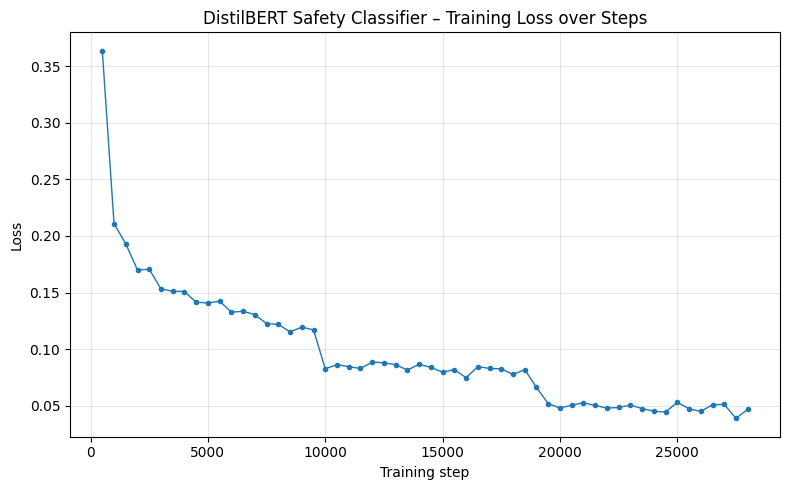

,loss,grad_norm,learning_rate,epoch,step
0,0.3639,4.665610,0.000020,0.053146,500
1,0.2110,5.697540,0.000019,0.106293,1000
2,0.1931,2.953689,0.000019,0.159439,1500
3,0.1699,5.536335,0.000019,0.212585,2000
4,0.1706,2.254469,0.000018,0.265731,2500


In [13]:
# Training loss curve over steps

import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract loss logs from Trainer
logs = trainer.state.log_history

loss_rows = [l for l in logs if "loss" in l]
loss_df = pd.DataFrame(loss_rows)

# Sometimes there is no 'epoch' column for the very first logs, fill if needed
if "epoch" not in loss_df.columns:
    loss_df["epoch"] = None

# 2. Plot loss vs. training step
plt.figure(figsize=(8, 5))
plt.plot(loss_df["step"], loss_df["loss"], marker=".", linewidth=1)
plt.title("DistilBERT Safety Classifier – Training Loss over Steps")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

loss_df.head()

## Training Loss per Epoch

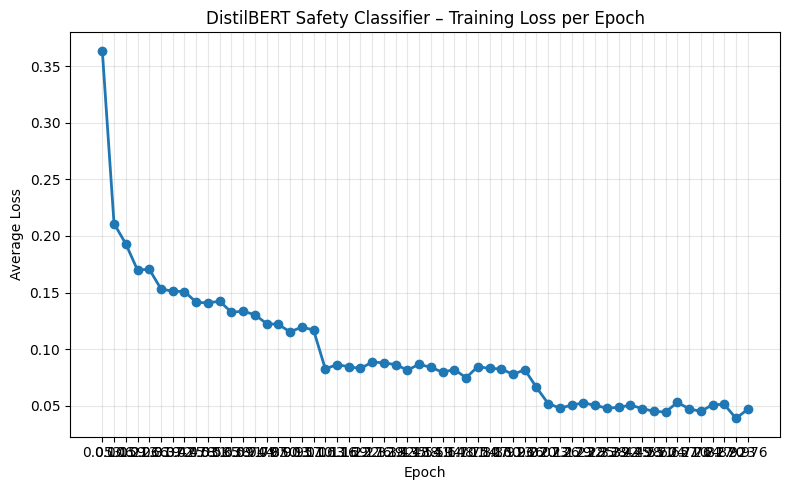

,loss
epoch,
0.053146,0.3639
0.106293,0.2110
0.159439,0.1931
0.212585,0.1699
0.265731,0.1706
0.318878,0.1532
0.372024,0.1511
0.425170,0.1509
0.478316,0.1414


In [14]:
# Training loss averaged per epoch

import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# Extract rows that contain both loss + epoch
epoch_rows = [l for l in logs if "loss" in l and "epoch" in l]
epoch_df = pd.DataFrame(epoch_rows)

# Group by epoch and compute average loss per epoch
epoch_loss = epoch_df.groupby("epoch")["loss"].mean()

plt.figure(figsize=(8,5))
plt.plot(epoch_loss.index, epoch_loss.values, marker="o", linewidth=2)
plt.title("DistilBERT Safety Classifier – Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True, alpha=0.3)
plt.xticks(epoch_loss.index)
plt.tight_layout()
plt.show()

epoch_loss

## ROC curves per class (one-vs-rest)

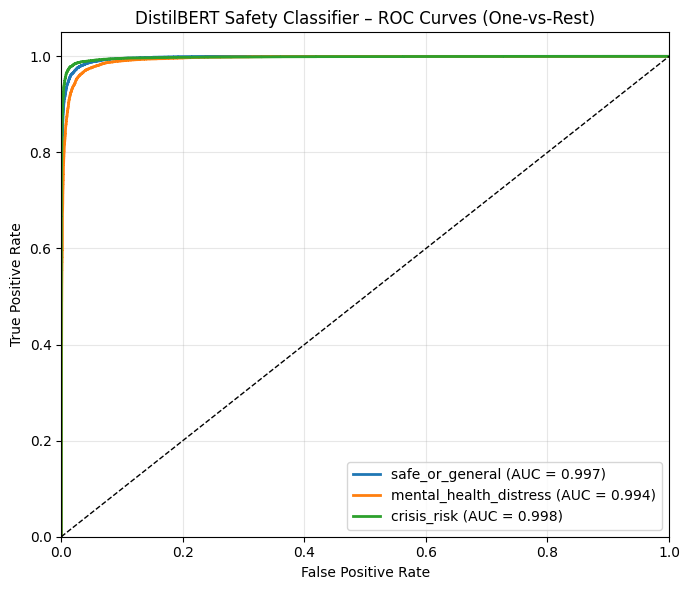

{0: np.float64(0.9971278235816385),
 1: np.float64(0.9939691380060824),
 2: np.float64(0.9976112814055249)}

In [15]:
# ROC curves per class (one-vs-rest)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 1. Get logits + labels from validation set (again, if needed)
pred_output = trainer.predict(val_ds)
y_true = pred_output.label_ids               # shape: (N,)
logits = pred_output.predictions             # shape: (N, 3)
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

# 2. Binarize true labels for one-vs-rest ROC
classes = [0, 1, 2]
y_true_bin = label_binarize(y_true, classes=classes)  # shape: (N, 3)

label_names = ["safe_or_general", "mental_health_distress", "crisis_risk"]

# 3. Compute ROC + AUC per class
fpr = {}
tpr = {}
roc_auc = {}

for i, c in enumerate(classes):
    fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

# 4. Plot
plt.figure(figsize=(7, 6))
for c in classes:
    plt.plot(
        fpr[c],
        tpr[c],
        lw=2,
        label=f"{label_names[c]} (AUC = {roc_auc[c]:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DistilBERT Safety Classifier – ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

roc_auc

## **ROC Curve and AUC Analysis**

The ROC curves for the DistilBERT Safety Classifier show excellent separability between the three safety classes:

* safe_or_general (AUC = 0.997)
* mental_health_distress (AUC = 0.994)
* crisis_risk (AUC = 0.998)

## Key Insights

1. All three AUC scores are above 0.99, indicating that the classifier is highly effective at distinguishing each class from the others in a one-vs-rest evaluation.

2. The ROC curves rise sharply toward the top-left corner, which reflects a very low false-positive rate paired with a high true-positive rate.

3. Crisis risk shows the strongest separability (AUC = 0.998), suggesting the model is especially confident when identifying high-risk messages.

4. Safe or general messages also show strong separability, meaning the model rarely confuses safe messages with distress or crisis categories.

5. Mental health distress has slightly more overlap with other classes (AUC = 0.994), which is expected given its conceptual closeness to both safe and crisis content.

## Conclusion

Overall, the ROC–AUC metrics confirm that the model has learned clear decision boundaries across all safety levels. This level of performance suggests the classifier is robust and reliable for real-world deployment where misclassification costs can be high.

## Precision–Recall curves per class

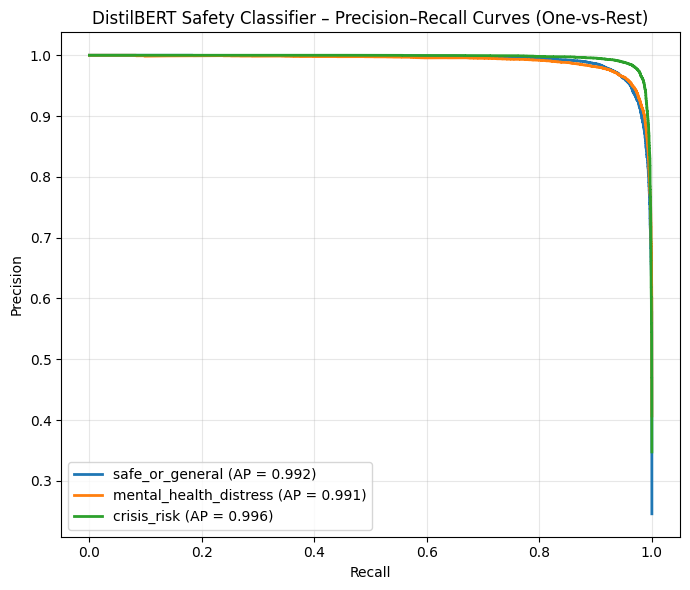

In [16]:
# Precision–Recall curves for each class (one-vs-rest)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Get predictions (logits → probabilities)
pred_output = trainer.predict(val_ds)
y_true = pred_output.label_ids
logits = pred_output.predictions
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

# 2. Binarize labels for one-vs-rest format
classes = [0, 1, 2]
y_true_bin = label_binarize(y_true, classes=classes)

label_names = ["safe_or_general", "mental_health_distress", "crisis_risk"]

# 3. Compute precision-recall curve + average precision for each class
plt.figure(figsize=(7, 6))

for i, class_id in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs[:, i])

    plt.plot(recall, precision, lw=2,
             label=f"{label_names[i]} (AP = {ap:.3f})")

# 4. Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("DistilBERT Safety Classifier – Precision–Recall Curves (One-vs-Rest)")
plt.grid(alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## **Precision–Recall Curve and Average Precision (AP) Analysis**

The Precision–Recall (PR) curves for the DistilBERT Safety Classifier demonstrate strong performance across all three safety levels. Each class maintains high precision even as recall increases, indicating strong reliability in distinguishing safety-critical messages.

## Average Precision Scores:

* safe_or_general: AP = 0.992
* mental_health_distress: AP = 0.991
* crisis_risk: AP = 0.996

## Key Insights

1. All classes exceed 0.99 AP, showing that the model consistently maintains high precision even when recall increases.

2. Crisis risk shows the strongest performance (AP = 0.996), indicating the classifier is highly reliable when identifying high-risk messages where mistakes are costly.

3. Safe or general messages (AP = 0.992) are also well-distinguished, meaning the model rarely mislabels them as distress or crisis.

4. Mental health distress (AP = 0.991) exhibits slightly more overlap with the other categories, which is expected given its conceptual closeness to both general emotional and crisis content.

5. The PR curves stay near the top of the graph until very high recall values, reflecting consistent high precision across thresholds.

## Conclusion

The Precision–Recall results confirm that the DistilBERT Safety Classifier provides strong and reliable discrimination across all safety categories. This level of performance makes the model suitable for real-world deployment, particularly in applications where minimizing false positives and accurately identifying risk-related content are essential.

## See how it behaves on real text

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

model_path = "/content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_safety_v1"

safety_tokenizer = AutoTokenizer.from_pretrained(model_path)
safety_model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda")
safety_model.eval()

id2label = {
    0: "safe_or_general",
    1: "mental_health_distress",
    2: "crisis_risk",
}

def predict_safety(text):
    inputs = safety_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        outputs = safety_model(**inputs)
    probs = outputs.logits.softmax(dim=-1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    return {
        "label_id": pred_id,
        "label": id2label[pred_id],
        "confidence": float(probs[pred_id]),
        "all_probs": probs.tolist()
    }

# Try a few examples
print(predict_safety("Today was okay, just a bit stressful."))
print(predict_safety("I feel really overwhelmed and anxious lately."))
print(predict_safety("I don't want to be here anymore."))

{'label_id': 1, 'label': 'mental_health_distress', 'confidence': 0.9959233999252319, 'all_probs': [0.003175091464072466, 0.9959233999252319, 0.0009015329997055233]}
{'label_id': 1, 'label': 'mental_health_distress', 'confidence': 0.9995786547660828, 'all_probs': [0.00026193191297352314, 0.9995786547660828, 0.0001594250788912177]}
{'label_id': 2, 'label': 'crisis_risk', 'confidence': 0.9844368696212769, 'all_probs': [0.012833497487008572, 0.002729610539972782, 0.9844368696212769]}
